In [2]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from codes.solvers import solver
from codes.tb import transforms, utils
from codes.model import Model
from codes import mf
from codes import observables

In [23]:
def density_matrix_tb(hop_vecs, mf_sol, filling=2): 
    fermi_energy = mf.fermi_on_grid(mf_sol, filling)
    rho_grid = mf.density_matrix(mf_sol, fermi_energy)
    rho_tb = transforms.kham_to_tb(rho_grid, hop_vecs)
    return rho_tb

def total_energy(ham_tb, rho_tb): 
    return np.real(observables.expectation_value(rho_tb, ham_tb))


In [39]:
U0 = 1
filling = 2

hopp = np.kron(np.array([[0, 1], [0, 0]]), np.eye(2))
h_0 = {(0,): hopp + hopp.T.conj(), (1,): hopp, (-1,): hopp.T.conj()}
h_int_U0 = {
        (0,): U0 * np.kron(np.eye(2), np.ones((2, 2))),
    }


def model_U(U):
    h_int = {
        (0,): U * np.kron(np.eye(2), np.ones((2, 2))),
    }
    return Model(h_0=h_0, h_int=h_int, filling=filling)

hop_vecs = model_U(U0).h_0.keys()

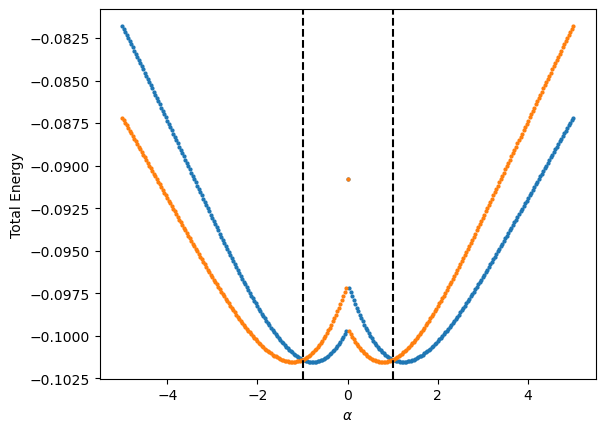

In [93]:
nk = 200
ks = np.linspace(-np.pi, np.pi, nk, endpoint=False)
hamiltonians_0 = transforms.tb_to_khamvector(h_0, nk, ndim=1, ks=ks) 
guess = utils.generate_guess(frozenset(h_int_U0), len(list(h_0.values())[0]))

def groundstate(U):
    _model = model_U(U)
    mf_sol = solver(_model, guess, nk=4000)
 
    return mf_sol

mf_sol_groundstate = groundstate(U0)
mf_sol_groundstate = transforms.tb_to_khamvector(mf_sol_groundstate, nk, ndim=1, ks=ks)

@np.vectorize
def mfRescaled(alpha, mf0=mf_sol_groundstate):
    hamiltonian = hamiltonians_0 + mf0 * alpha
    rho_tb = density_matrix_tb(hop_vecs, hamiltonian)
    hamiltonian = hamiltonians_0 + np.sign(alpha) * mf0
    hamiltonian_tb = transforms.kham_to_tb(hamiltonian, hop_vecs)
    return total_energy(hamiltonian_tb, rho_tb)

alphas = np.linspace(-5, 5, 301)
plt.plot(alphas, mfRescaled(alphas), 'o', ms=2)
plt.plot(-alphas, mfRescaled(alphas), 'o', ms=2)
plt.axvline(x=1, c="k", ls="--")
plt.axvline(x=-1, c="k", ls="--")
plt.ylabel("Total Energy")
plt.xlabel(r"$\alpha$")
# plt.ylim(-4.6, -4.5)
plt.show()

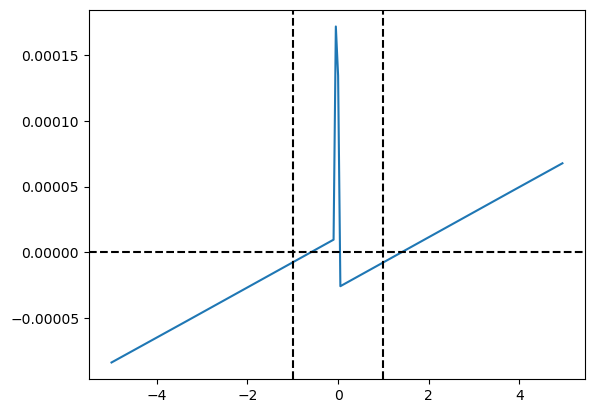

In [22]:
plt.plot(alphas[:-1], np.diff(mfRescaled(alphas)))
# plt.plot(-alphas[:-1], -np.diff(mfRescaled(alphas)))
plt.axhline(0, ls='--', c='k')
plt.axvline(x=1, c="k", ls="--")
plt.axvline(x=-1, c="k", ls="--")
# plt.ylim(-4, -2)
plt.show()